In [1]:
import os
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import matplotlib
import matplotlib.pyplot as plt

### Functions for model

In [2]:
# Dataset and Transformations
class ResizeTransform:
    def __init__(self, size):
        self.size = size

    def __call__(self, img, target):
        img = T.Resize((self.size, self.size))(img)
        return img, target

class RoboflowDataset(Dataset):
    def __init__(self, root, folder='train', transforms=None):
        self.root = root
        self.transforms = transforms
        self.folder = folder
        if not folder in ['test', 'train', 'valid']:
            print("Invalid folder parameter. Must be 'valid', 'test' or 'train'. Using default train folder.") 
            self.folder = "train"
            
        self.imgs = sorted(os.listdir(os.path.join(root, f"{self.folder}/images")))
        self.annotations = sorted(os.listdir(os.path.join(root, f"{self.folder}/labels")))

        # Filter images with valid annotations
        self.data = []
        for img, ann in zip(self.imgs, self.annotations):
            ann_path = os.path.join(root, f"{self.folder}/labels", ann)
            if os.path.exists(ann_path):
                with open(ann_path, 'r') as f:
                    lines = f.readlines()
                if len(lines) > 0:  # Check if there are any annotations
                    self.data.append((img, ann))

        self.to_tensor = T.ToTensor()

    def __getitem__(self, idx):
        img_name, ann_name = self.data[idx]
        img_path = os.path.join(self.root, f"{self.folder}/images", img_name)
        ann_path = os.path.join(self.root, f"{self.folder}/labels", ann_name)

        img = Image.open(img_path).convert("RGB")
        img = self.to_tensor(img)

        # Parse YOLO annotations
        with open(ann_path, 'r') as f:
            lines = f.readlines()

        boxes = []
        labels = []
        for line in lines:
            label, x_center, y_center, width, height = map(float, line.strip().split())
            xmin = (x_center - width / 2) * img.shape[2]
            xmax = (x_center + width / 2) * img.shape[2]
            ymin = (y_center - height / 2) * img.shape[1]
            ymax = (y_center + height / 2) * img.shape[1]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(int(label))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Exclude entries with no boxes
        if boxes.numel() == 0:
            raise ValueError(f"Empty boxes for image {img_name}")

        target = {"boxes": boxes, "labels": labels}
        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.data)

def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

### Plot mAP graph

In [3]:
import csv

def read_rcnn_csv(path):
    # Initialize lists to store the mAP values and epochs
    epochs = []
    train_map_50 = []
    train_map_50_95 = []
    test_map_50 = []
    test_map_50_95 = []

    # Read the CSV file and extract the data
    with open(path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip the header row
        for row in reader:
            epochs.append(int(row[0]))
            train_map_50.append(float(row[4]))
            train_map_50_95.append(float(row[5]))
            test_map_50.append(float(row[6]))
            test_map_50_95.append(float(row[7]))
    
    return epochs, train_map_50, train_map_50_95, test_map_50, test_map_50_95

def read_yolo_csv(path):
    dd = {}
    headers = []
    with open(path, newline="") as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if dd == {}:
                for i in range(len(row)):
                    dd[row[i]] = [] 
                    headers.append(row[i])
            else:
                for i in range(len(row)):
                    dd[headers[i]].append(row[i])
    return dd


data_dict = read_yolo_csv("yolov8s_training_stats.csv")

print(data_dict.keys())

dict_keys(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2'])


0.3878
0.60375


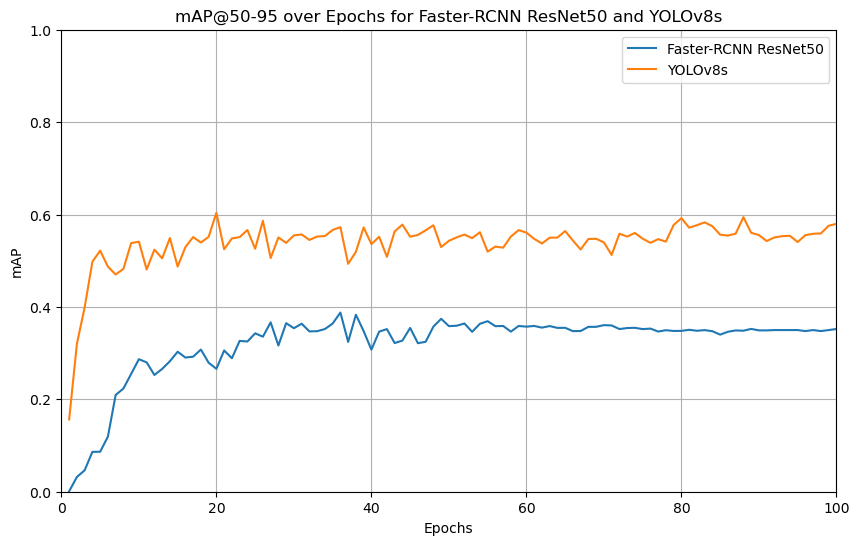

In [4]:
import matplotlib.pyplot as plt

# Define the CSV file path
rcnn_file = 'rcnn_training_stats.csv'
yolo_file = 'yolov8s_training_stats.csv'

epochs, train_map_50, train_map_50_95, test_map_50, test_map_50_95 = read_rcnn_csv(rcnn_file)
yolo_data = read_yolo_csv(yolo_file)

print(max(test_map_50_95))
print(max(yolo_data["metrics/mAP50-95(B)"]))

# Plotting the mAP values over epochs
plt.figure(figsize=(10, 6))

# Plot test set mAP@50
# plt.plot(epochs, test_map_50, label="Faster-RCNN ResNet50") # fasterrcnn_resnet50_fpn
# plt.plot(epochs, [float(i) for i in yolo_data["metrics/mAP50(B)"]], label="YOLOv8s")

# Plot test set mAP@50-95
plt.plot(epochs, test_map_50_95, label="Faster-RCNN ResNet50") # fasterrcnn_resnet50_fpn
plt.plot(epochs, [float(i) for i in yolo_data["metrics/mAP50-95(B)"]], label="YOLOv8s")

# Plot mAP@50 and mAP@50-95 for Train and Test sets
# plt.plot(epochs, train_map_50, label="Train mAP@50", marker='o')
# plt.plot(epochs, train_map_50_95, label="Train mAP@50-95", marker='o')
# plt.plot(epochs, test_map_50, label="Test mAP@50", marker='x')
# plt.plot(epochs, test_map_50_95, label="Test mAP@50-95", marker='x')

# Adding labels and title
plt.xlabel("Epochs")
plt.ylabel("mAP")
plt.title("mAP@50-95 over Epochs for Faster-RCNN ResNet50 and YOLOv8s")
plt.legend(loc="best")
plt.grid(True)

plt.ylim(0,1)
plt.xlim(0, max(epochs))

# Show the plot
plt.show()

### Visualisation Functions

In [ ]:
import random
import numpy as np
import cv2
from ultralytics import YOLO

class_dict = {
    0: "ERP",
    1: "GIVE_WAY",
    2: "INFO_ONE_WAY",
    3: "MANDATORY_KEEP_LEFT",
    4: "MANDATORY_SPLIT_WAY",
    5: "NO_ENTRY",
    6: "NO_LEFT_TURN",
    7: "NO_RIGHT_TURN",
    8: "NO_STOPPING",
    9: "NO_WAITING",
    10: "PEDESTARIAN_CROSSING",
    11: "PEDESTARIAN_USE_CROSSING",
    12: "PROHIBITORY_NO_JAYWALKING",
    13: "PROHIBITORY_SPD_LIMIT",
    14: "PROHIB_NO_VEH_OVER_HEIGHT_45",
    15: "REDUCE_SPEED_NOW",
    16: "SLOW",
    17: "STOP",
    18: "TURN_ARROW",
    19: "U_TURN",
    20: "WARNING_CURVE",
}

def visualize_image_with_boxes(img, boxes, scores, labels, show=False):
    """
    Visualize a single image with bounding boxes.
    :param img: Image as a NumPy array (HWC)
    :param boxes: Bounding boxes as a NumPy array [[xmin, ymin, xmax, ymax], ...]
    :param scores: Confidence scores as a NumPy array
    :param labels: Labels as a NumPy array
    """
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)
    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin

        # Create a rectangle patch
        rect = matplotlib.patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Add label and score
        label = f"{labels[i]}: {scores[i]:.2f}"
        ax.text(xmin, ymin - 10, label, color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    # Convert the figure to a NumPy array
    fig.canvas.draw()  # Draw the canvas
    img_with_boxes = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img_with_boxes = img_with_boxes.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    if show:
        plt.show()

    plt.close(fig)  # Close the plot to free resources

    return img_with_boxes

def draw_boxes(img, boxes, scores, labels, show=False):
    """
    Visualize a single image with bounding boxes using OpenCV.
    :param img: Image as a NumPy array (HWC)
    :param boxes: Bounding boxes as a NumPy array [[xmin, ymin, xmax, ymax], ...]
    :param scores: Confidence scores as a NumPy array
    :param labels: Labels as a NumPy array
    :param show: Boolean to show the image after drawing boxes
    """
    # Make a copy of the image to draw on
    img_with_boxes = img.copy()

    # Iterate through each bounding box, label, and score
    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)

        # Draw the rectangle (using BGR color format for OpenCV)
        color = (0, 0, 255)  # Red in BGR format for bounding box
        thickness = 2
        img_with_boxes = cv2.rectangle(img_with_boxes, (xmin, ymin), (xmax, ymax), color, thickness)

        # Prepare the label with the score
        label = f"{class_dict[int(labels[i])]}: {scores[i]:.2f}"

        # Set font for the label
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.6
        font_thickness = 2
        text_size, _ = cv2.getTextSize(label, font, font_scale, font_thickness)
        text_width, text_height = text_size

        # Draw background for text
        text_bg = (0, 0, 255)  # Red background for text box
        img_with_boxes = cv2.rectangle(img_with_boxes, (xmin, ymin - text_height - 10), (xmin + text_width, ymin), text_bg, -1)

        # Put the label text on the image
        text_color = (255, 255, 255)  # White color for the text
        img_with_boxes = cv2.putText(img_with_boxes, label, (xmin, ymin - 5), font, font_scale, text_color, font_thickness)

        img_with_boxes = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

    if show:
        # Display the image with bounding boxes
        cv2.imshow('Image with Bounding Boxes', img_with_boxes)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    return img_with_boxes


def visualize_predictions(model, img_paths, device, transforms=None, img_size=800, threshold=0.5, show=False):
    model.eval()
    img_arrs = []

    with torch.no_grad():
        for i, img_path in enumerate(img_paths):
            img = Image.open(img_path).convert("RGB")
            to_tensor = T.ToTensor()
            img = to_tensor(img)
            if transforms: 
                img, _ = transforms(img, {})
            img_tensor = img.to(device).unsqueeze(0)  # Add batch dimension

            # Perform inference
            output = model(img_tensor)[0]

            # Convert tensors to numpy for visualization
            img_np = img.permute(1, 2, 0).cpu().numpy()  # Convert image to HWC
            img_np = (img_np * 255).astype('uint8')  # Scale to [0, 255]

            # Extract predictions above the confidence threshold
            boxes = output["boxes"].cpu().numpy()
            scores = output["scores"].cpu().numpy()
            labels = output["labels"].cpu().numpy()

            high_conf_idx = scores > threshold
            boxes = boxes[high_conf_idx]
            scores = scores[high_conf_idx]
            labels = labels[high_conf_idx]

            # Visualize the image and predictions
            img_arr = draw_boxes(img_np, boxes, scores, labels, show=show)
            img_arrs.append(img_arr)

            cv2.imwrite(f"rcnn_result_{i}.jpg", img_arr)

    return img_arrs
            

def visualize_predictions_randomized(model, dataset, device, num_images=5, threshold=0.5):
    """
    Visualize predictions on randomly selected test images.
    :param model: Trained Faster R-CNN model
    :param dataset: The test dataset (not DataLoader, so we can randomly index)
    :param device: Torch device (CPU or CUDA)
    :param num_images: Number of test images to visualize
    :param threshold: Confidence threshold for predictions
    """
    model.eval()  # Set model to evaluation mode

    # Select random indices
    random_indices = random.sample(range(len(dataset)), num_images)

    with torch.no_grad():
        for idx in random_indices:
            img, target = dataset[idx]
            img_tensor = img.to(device).unsqueeze(0)  # Add batch dimension

            # Perform inference
            output = model(img_tensor)[0]

            # Convert tensors to numpy for visualization
            img_np = img.permute(1, 2, 0).cpu().numpy()  # Convert image to HWC
            img_np = (img_np * 255).astype('uint8')  # Scale to [0, 255]

            # Extract predictions above the confidence threshold
            boxes = output["boxes"].cpu().numpy()
            scores = output["scores"].cpu().numpy()
            labels = output["labels"].cpu().numpy()

            high_conf_idx = scores > threshold
            boxes = boxes[high_conf_idx]
            scores = scores[high_conf_idx]
            labels = labels[high_conf_idx]

            # Visualize the image and predictions
            visualize_image_with_boxes(img_np, boxes, scores, labels)

def get_predictions_yolo(weights_path, img_paths, img_size=800):
    # Load a model
    model = YOLO(weights_path)  # pretrained YOLO11n model

    # Run batched inference on a list of images
    results = model(img_paths)  # return a list of Results objects

    # Process results list
    for i, result in enumerate(results):
        boxes = result.boxes  # Boxes object for bounding box outputs
        masks = result.masks  # Masks object for segmentation masks outputs
        keypoints = result.keypoints  # Keypoints object for pose outputs
        probs = result.probs  # Probs object for classification outputs
        obb = result.obb  # Oriented boxes object for OBB outputs
        result.show()  # display to screen
        result.save(filename=f"yolo_result_{i}.jpg")  # save to disk


In [ ]:
from util import plot_imgs
import cv2

# Visualize random predictions from the test dataset
model = get_model(num_classes=22)
model.load_state_dict(torch.load("/home/s14-htx/Documents/GitHub/GPU_file_sharing/RCNN_100_16.pth", weights_only=True))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Params
img_size = 800

# Dataset and DataLoader for the test set
dataset_path = "/home/s14-htx/Documents/GitHub/GPU_file_sharing/SG-Road-Signs-2"
transforms = ResizeTransform(img_size)
test_dataset = RoboflowDataset(dataset_path, folder='test', transforms=transforms)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# print(len(test_dataset))
# img = visualize_predictions_randomized(model, test_dataset, device, num_images=5, threshold=0.5)

# Predict on RCNN
img_folder = "/home/s14-htx/Documents/GitHub/GPU_file_sharing/SG-Road-Signs-2/test/images/"
img_ls = os.listdir(img_folder)
img_files = [file for file in img_ls if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
img_names = random.sample(img_files, 5)
# img_names = ["0031_png.rf.bb63fdd0cfdccce6714de461cfc260fc.jpg"]
rcnn_img_ls = visualize_predictions(model, [img_folder+i for i in img_names], device, transforms)

# Predict on YOLOv8
yolo_weights = "/home/s14-htx/Documents/GitHub/SG-Road-Signs-Detection/yolov8s_runs/detect/train/weights/best.pt"
get_predictions_yolo(yolo_weights, [img_folder+i for i in img_names])


/home/s14-htx/anaconda3/envs/roadsigns/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/s14-htx/anaconda3/envs/roadsigns/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



0: 800x800 1 MANDATORY_SPLIT_WAY, 2.3ms
1: 800x800 1 ERP, 1 MANDATORY_SPLIT_WAY, 2.3ms
2: 800x800 (no detections), 2.3ms
3: 800x800 1 NO_ENTRY, 1 NO_LEFT_TURN, 1 NO_WAITING, 2.3ms
4: 800x800 1 NO_ENTRY, 1 PROHIBITORY_NO_JAYWALKING, 2.3ms
Speed: 0.7ms preprocess, 2.3ms inference, 0.3ms postprocess per image at shape (1, 3, 800, 800)
Opening in existing browser session.


Opening in existing browser session.
Opening in existing browser session.
Opening in existing browser session.


[47349:47349:1204/144508.940333:ERROR:object_proxy.cc(576)] Failed to call method: org.freedesktop.ScreenSaver.GetActive: object_path= /org/freedesktop/ScreenSaver: org.freedesktop.DBus.Error.NotSupported: This method is not part of the idle inhibition specification: https://specifications.freedesktop.org/idle-inhibit-spec/latest/
Created TensorFlow Lite XNNPACK delegate for CPU.
Attempting to use a delegate that only supports static-sized tensors with a graph that has dynamic-sized tensors (tensor#-1 is a dynamic-sized tensor).
[47349:47378:1204/144511.025981:ERROR:registration_request.cc(291)] Registration response error message: DEPRECATED_ENDPOINT
